## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Downloading and Extracting Dataset](#2.1)
    -  [2.2.Visualizing Dataset](#2.2)
    -  [2.3.Splitting Dataset](#2.3)
    -  [2.4.Pytorch DataLoaders](#2.4)
-  [3.Initializing pre-trained model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs MiniBatch](#5.1)
    -  [5.2.Plotting Accuracy vs MiniBatch](#5.2)
    -  [5.3.Plotting Loss vs Epoch](#5.3)
    -  [5.4.Plotting Accuracy vs Epoch](#5.4)
-  [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
# !pip install timm
import timm

/home/frozenwolf/miniconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/frozenwolf/miniconda3/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
from sklearn import cluster
from zipfile import ZipFile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import os
import random
import pickle

torch.cuda.empty_cache()
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

sns.set_style("darkgrid")



### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Downloading and Extracting Dataset <a class="anchor" id="2.1"></a>

In [3]:
path = "electricity-dataset/"
labels = {os.listdir(path)[i]:i for i in range(3)}


train_img = {}
train_label = []

test_img = {}
test_label = []

val_img = {}
val_label = []

database_img = {}

for i in os.listdir(path):
    for j in os.listdir(path+i):
        if "test" in j:
            test_img[labels[i]] =[path+i+'/'+j+'/'+k for k in os.listdir(path+i+'/'+j)]

        else:
            train_img[labels[i]] =[path+i+'/'+j+'/'+k for k in os.listdir(path+i+'/'+j)]

            val_img[labels[i]] =train_img[labels[i]][-4:]
            
            train_img[labels[i]]  = train_img[labels[i]][:-4]

            database_img[labels[i]] = train_img[labels[i]][-10:]
            
#             train_img = train_img[:-8]

#### 3.Splitting Dataset <a class="anchor" id="2.3"></a>

#### 4.Pytorch DataLoaders <a class="anchor" id="2.4"></a>

In [4]:
import random
import itertools
from PIL import Image

class Dataset(Dataset):
    def __init__(self,x,transform = 'T.Resize((224,224))'):
        self.transform = transform
        self.x = x
        self.len = 3*(len(self.x[0]))**2
   
    def __len__(self):
        return self.len
    
    def __getitem__(self,i):
        x = [0,1,2]
        c1 = random.choice(x)
#         print(c1)
        x.remove(c1)
        c2 = random.choice(x)
        
        anchor_i = random.randrange(len(self.x[c1]))
        i1 = random.randrange(len(self.x[c1]))
        i2 = random.randrange(len(self.x[c2]))
        
        anchor = Image.open(self.x[c1][anchor_i]).convert('RGB')
        img1 = Image.open(self.x[c1][i1]).convert('RGB')
        img2 = Image.open(self.x[c2][i2]).convert('RGB')
            
        return torch.FloatTensor(np.asarray(self.transform(anchor))), torch.FloatTensor(np.asarray(self.transform(img1))), torch.FloatTensor(np.asarray(self.transform(img2))),torch.FloatTensor([1]), torch.FloatTensor([0])


batch_size = 32

transforms_train = T.Compose([
        T.Resize((224,224)),
        T.RandomRotation(degrees=(-10, 10)),
        T.RandomHorizontalFlip(),
#         T.RandomGrayscale(0.5),
#         T.RandomVerticalFlip(),
        T.ToTensor(),
        
    ])

transforms_test = T.Compose([
        T.Resize((224,224)),
        T.ToTensor(),
    ])

train_dataset = Dataset(train_img,transform =transforms_train)
validation_dataset = Dataset(val_img,transform =transforms_test)
test_dataset = Dataset(test_img,transform =transforms_test)

train_dataloader = DataLoader(train_dataset , batch_size = batch_size , shuffle = True )
validation_dataloader = DataLoader(validation_dataset , batch_size = batch_size , shuffle = True )
test_dataloader = DataLoader(test_dataset , batch_size = batch_size , shuffle = True )

In [5]:
next(iter(validation_dataloader))[0].shape

torch.Size([32, 3, 224, 224])

### 3.Initializing pre-trained model <a class="anchor" id="3"></a>

In [6]:
import torch.nn.functional as F

class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):

        super(ViTBase16, self).__init__()

        self.model = timm.create_model("vit_tiny_patch16_224", pretrained=False)
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


class MatchingModel(nn.Module):
    def __init__(self, device):

        super(MatchingModel, self).__init__()

        self.model_vit = ViTBase16(3, pretrained=True)

        self.model_vit.load_state_dict(torch.load("vit_tiny_patch16_224", map_location=torch.device(device)))

        self.model_vit.model.head = nn.Identity()
        
        # self.T = T.Compose([T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        

        for param in self.model_vit.parameters():
            param.requires_grad = True
            
        
#         self.l1 = nn.Linear(4,16)
#         self.l1 = nn.Linear(2,16)
        self.out = nn.Linear(1,1)
        
    
    def euclidean_dist(self, x1, x2):
        return (x1-x2).pow(2).sum(1)
            
    def forward(self, x1, x2, x3=None): #anchor, T, F
        x1_ = self.model_vit(x1) 
        x2_ = self.model_vit(x2)
                
        y2 = self.euclidean_dist(x1_, x2_).view(-1,1) #anchor - T      

        
#         if x3 is not None:
        x3_ = self.model_vit(x3)
        y3 = self.euclidean_dist(x1_, x3_).view(-1,1) #anchor -F
       
        return y2, y3
#             return torch.sigmoid(self.out(torch.cat((y2, y4), dim=1))), torch.sigmoid(self.out(torch.cat((y2, y4), dim=1))), (y2, y3, y4, y5)
        
#         else:
#             return torch.sigmoid(self.out(torch.cat((y2, y4), dim=1))), (y2, y4)

device = 'cuda'
model = MatchingModel(device='cuda')

model = model.to(device)

model(torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 3, 224, 224).to('cuda'), torch.randn(2, 3, 224, 224).to('cuda'))


(tensor([[128.9888],
         [ 95.2902]], device='cuda:0', grad_fn=<ViewBackward0>),
 tensor([[127.3426],
         [170.5652]], device='cuda:0', grad_fn=<ViewBackward0>))

### 4.Training <a class="anchor" id="4"></a>

In [7]:
lr = 0.001
epoch = 30
train_dataset_size = train_dataset.__len__()
validation_dataset_size = validation_dataset.__len__()
train_n_minibatches = train_dataloader.__len__()
validation_n_minibatches = validation_dataloader.__len__()


loss_history = [[],[]] #[[train], [validation]]
tri_loss_history = [[],[]]
accuracy_history = [[],[]] #[[train], [validation]]

criterion = nn.BCELoss() 
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self):
        super(TripletLoss, self).__init__()

    def forward(self, distance_positive, distance_negative, size_average=True):
        losses = F.relu(distance_positive - distance_negative)
        return losses.mean() if size_average else losses.sum()
    
tripletloss = TripletLoss()

In [15]:
best_val_loss = 100000
import gc

for e in range(epoch):
    print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
    for batch_idx , (a, x1, x2 ,y1, y2) in enumerate(train_dataloader):
        print(f"BATCH {batch_idx+1}/{train_n_minibatches}", end="\r")
        model.train() # Setting mode to train
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        
        x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
        

        p1, n1 = model(a, x1, x2)
        
        # Calculating Loss
        
        triloss = tripletloss(p1, n1)            
        triloss.backward()
        
        

        nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
        tri_loss_history[0].append(float(triloss.detach()))

        del x1, x2 ,y1, y2, triloss, p1, n1
        gc.collect()
        
        
        if batch_idx % (train_n_minibatches//2) == 0:
            # Printing Log
            print(f'TRILOSS for EPOCH {e+1} BATCH {batch_idx}/{train_n_minibatches} TRAIN LOSS : {tri_loss_history[0][-1]}')
            with torch.no_grad():
                # Calculating loss and accuracy for validation
                model.eval()
                for _batch_idx_ , (a, x1, x2 ,y1, y2) in enumerate(validation_dataloader):
                    torch.cuda.empty_cache()
                    print(f"BATCH {_batch_idx_+1}/{len(validation_dataloader)}", end="\r")
                    x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
                    p1, n1 = model(a, x1, x2)
                    triloss = tripletloss(p1, n1)    
                    tri_loss_history[1].append(float(triloss.detach()))

                    del x1, x2 ,y1, y2, triloss, p1, n1
                    gc.collect()         

                print(f'VALIDATION TRILOSS : {sum(tri_loss_history[1][-1:-validation_n_minibatches-1:-1])/validation_n_minibatches}',end = '\n')


    # Saving the model progress
    torch.save(model.state_dict(),'matching')
    n_validation_losses = len(validation_dataloader)
    x = sum(tri_loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses
    if best_val_loss>x:
        best_val_loss = x
        torch.save(model.state_dict(),'best_matching')

    #Log for e+1th epoch
    print(f'--------------------------------------------------------------------------------------------')
    print(f'TRAIN TRILoss for EPOCH {e+1}  TRAIN LOSS : {sum(tri_loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches}',end = ' ')
    n_validation_losses = validation_n_minibatches
    print(f'VALIDATION TRILOSS: {sum(tri_loss_history[1][-1:-1*n_validation_losses-1:-1])/n_validation_losses}')
    print('---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 1-------------------------------------------
TRILOSS for EPOCH 1 BATCH 0/338 TRAIN LOSS : 163.29306030273438
VALIDATION TRILOSS : 65.79791641235352
TRILOSS for EPOCH 1 BATCH 169/338 TRAIN LOSS : 11.189620971679688
VALIDATION TRILOSS : 46.454341888427734
--------------------------------------------------------------------------------------------
TRAIN TRILoss for EPOCH 1  TRAIN LOSS : 99.97148987809582 VALIDATION TRILOSS: 46.454341888427734
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 2-------------------------------------------
TRILOSS for EPOCH 2 BATCH 0/338 TRAIN LOSS : 59.18225860595703
VALIDATION TRILOSS : 44.26023864746094
TRILOSS for EPOCH 2 BATCH 169/338 TRAIN LOSS : 59.78337860107422
VALIDATION TRILOSS : 37.24494934082031
--------------------------------------------------------------------------------------------
TRAIN TRILoss for EPOCH 2  T

#### 3.Plotting Loss vs Epoch<a class="anchor" id="5.3"></a>

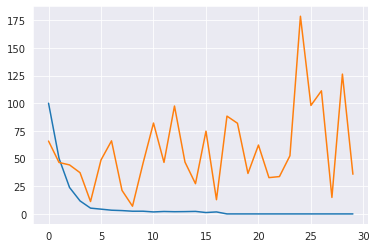

In [9]:
# Plotting Loss per epoch
tri_loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in tri_loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    tri_loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in tri_loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    tri_loss_per_epoch[1].append(temp/n_validation_losses)    

sns.lineplot(x=range(len(tri_loss_per_epoch[0])),y=tri_loss_per_epoch[0])
sns.lineplot(x=range(len(tri_loss_per_epoch[1])),y=tri_loss_per_epoch[1])
plt.show()

#### 4.Plotting Accuracy vs Epoch<a class="anchor" id="5.4"></a>

### 6.Loading and Testing<a class="anchor" id="6"></a>

In [12]:
test_triloss_history = [[],[]]

In [13]:
#Testing the model on test dataset

model.eval()
with torch.no_grad():
    for _batch_idx_ , (a, x1, x2 ,y1, y2) in enumerate(test_dataloader):
        torch.cuda.empty_cache()
        print(f"BATCH {_batch_idx_+1}/{len(test_dataloader)}", end="\r")
        x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
        p1, n1 = model(a, x1, x2)
        triloss = tripletloss(p1, n1)  
        test_triloss_history[1].append(float(triloss.detach()))
        
        del x1, x2 , y1, y2, a, p1, n1
        gc.collect()
    
    print(f'LOSS : {sum(test_triloss_history[1])/len(test_triloss_history[1])}  ')             

LOSS : 80.57171495499149  


In [14]:
model.load_state_dict(torch.load("best_matching"))

#Testing the model on test dataset

model.eval()
with torch.no_grad():
    for _batch_idx_ , (a, x1, x2 ,y1, y2) in enumerate(test_dataloader):
        torch.cuda.empty_cache()
        print(f"BATCH {_batch_idx_+1}/{len(test_dataloader)}", end="\r")
        x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
        p1, n1 = model(a, x1, x2)
        triloss = tripletloss(p1, n1)  
        test_triloss_history[1].append(float(triloss.detach()))
        
        del x1, x2 , y1, y2, a, p1, n1
        gc.collect()
    
    print(f'LOSS : {sum(test_triloss_history[1])/len(test_triloss_history[1])}  ')               

LOSS : 81.1187735733486  


In [16]:
model.load_state_dict(torch.load("best_matching_1"))

#Testing the model on test dataset

model.eval()
with torch.no_grad():
    for _batch_idx_ , (a, x1, x2 ,y1, y2) in enumerate(test_dataloader):
        torch.cuda.empty_cache()
        print(f"BATCH {_batch_idx_+1}/{len(test_dataloader)}", end="\r")
        x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
        p1, n1 = model(a, x1, x2)
        triloss = tripletloss(p1, n1)  
        test_triloss_history[1].append(float(triloss.detach()))
        
        del x1, x2 , y1, y2, a, p1, n1
        gc.collect()
    
    print(f'LOSS : {sum(test_triloss_history[1])/len(test_triloss_history[1])}  ')               

LOSS : 84.1679423070082  


In [17]:
model.load_state_dict(torch.load("matching_1"))

#Testing the model on test dataset

model.eval()
with torch.no_grad():
    for _batch_idx_ , (a, x1, x2 ,y1, y2) in enumerate(test_dataloader):
        torch.cuda.empty_cache()
        print(f"BATCH {_batch_idx_+1}/{len(test_dataloader)}", end="\r")
        x1, x2 , y1, y2, a = x1.to(device), x2.to(device) , y1.to(device), y2.to(device), a.to(device)
        p1, n1 = model(a, x1, x2)
        triloss = tripletloss(p1, n1)  
        test_triloss_history[1].append(float(triloss.detach()))
        
        del x1, x2 , y1, y2, a, p1, n1
        gc.collect()
    
    print(f'LOSS : {sum(test_triloss_history[1])/len(test_triloss_history[1])}  ')               

LOSS : 79.68982806777761  


In [18]:
best_val_loss

14.903121948242188

In [ ]:
# Loss for EPOCH 20  TRAIN LOSS : 0.1375014123817285 TRAIN ACCURACY : 97.39583333333333
# VALIDATION LOSS for EPOCH 20 : 0.817010223865509 VALIDATION ACCURACY : 75.0

# LOSS : 0.6753139793872833  ACCURACY : 74.47916666666666